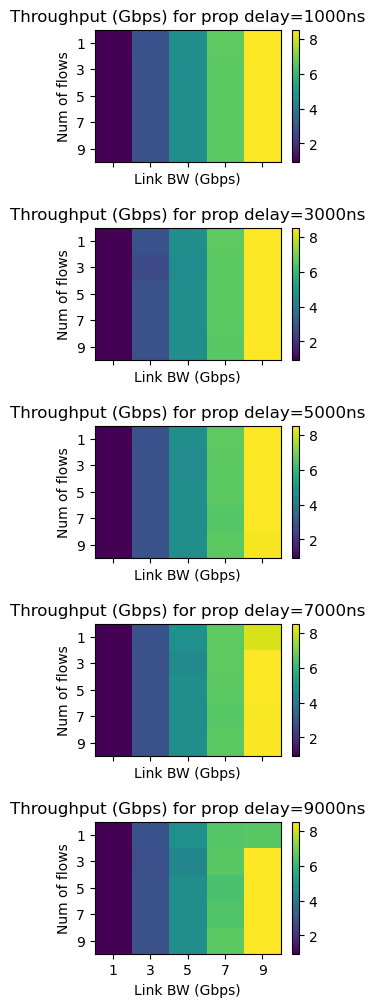

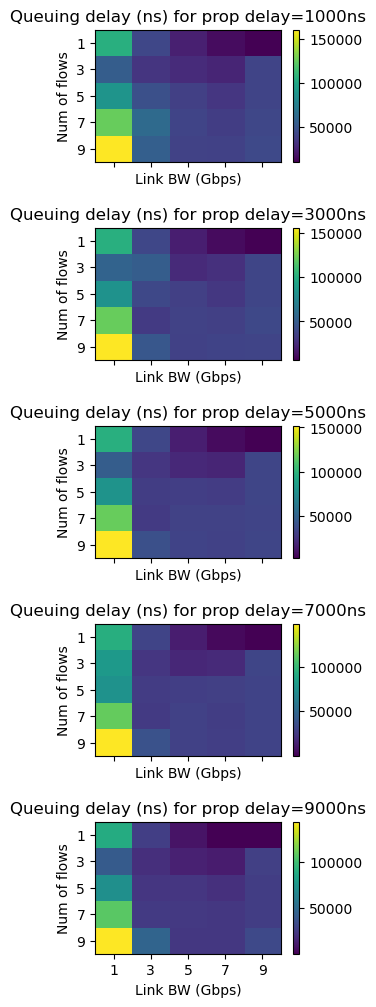

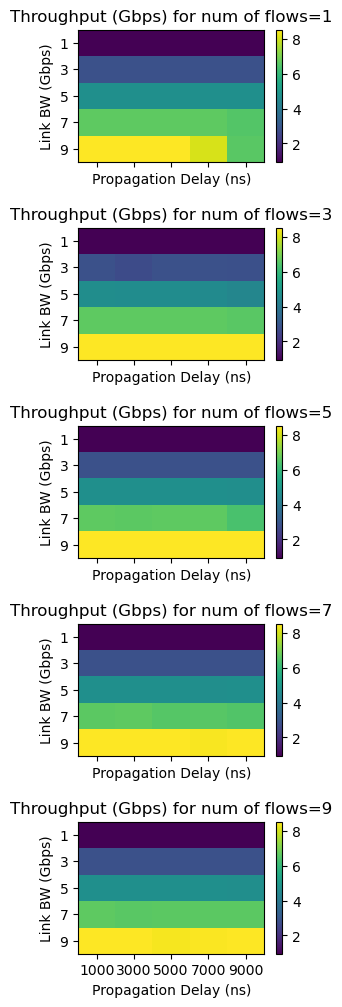

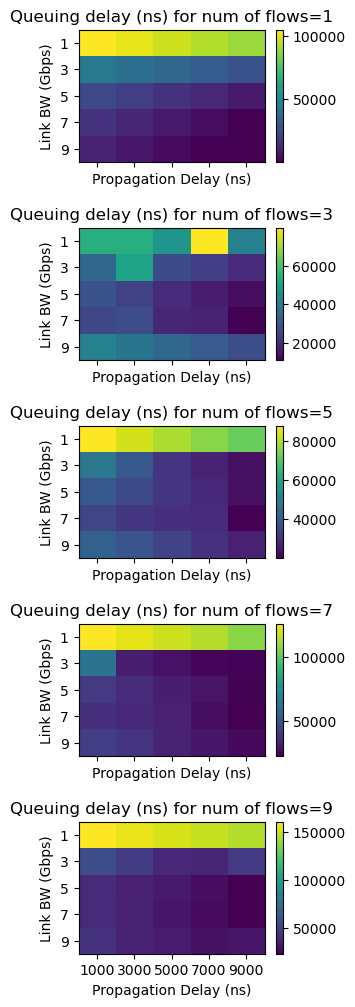

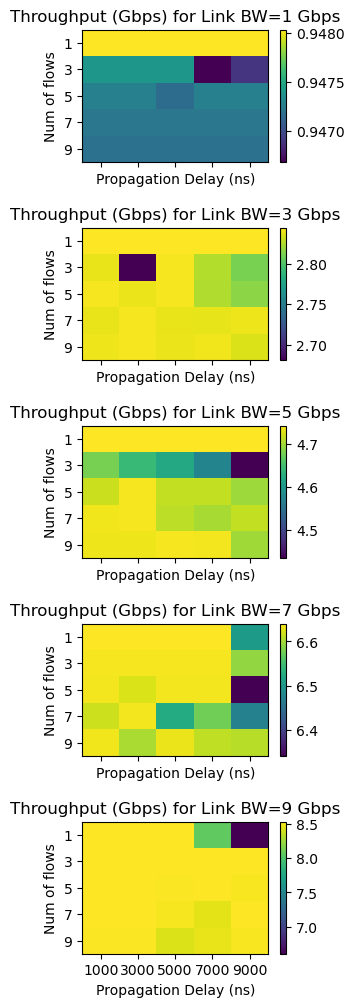

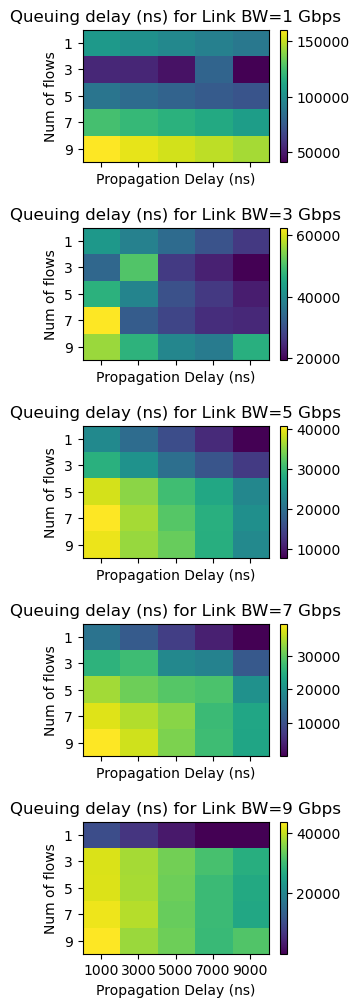

In [1]:
import pandas as pd
import os
from collections import deque
import numpy as np
import matplotlib.pyplot as plt

def parse_log_entry(line):
    parts = line.split()
    data_pkt = parts[10]=='U' 
    node = int(parts[1].split(':')[1])
    event_type = parts[4]
    if not data_pkt or node != 3 or event_type not in ['Enqu', 'Dequ']:
        return None
    else:
        timestamp = int(parts[0])
        queue_info = parts[2].split(':')
        port = int(queue_info[0])
        queue = int(queue_info[1])
        payload_size = int(parts[-1].split('(')[1].split(')')[0])
        queue_len= int(parts[3])
        return {
            'timestamp': timestamp,
            'node': node,
            'port': port,
            'queue': queue,
            'payload_size': payload_size,
            'event_type': event_type,
            'data_pkt': data_pkt,
            'queue_len': queue_len
        }

def calculate_throughput_and_delay(log_file):
    start_time=None
    end_time=None
    enqu_timestamps = deque()
    total_payload = 0
    queuing_delay_list = []
    queue_len_max=0
    queue_len_min=1000000
    with open(log_file, 'r') as file:
        for line in file:
            entry = parse_log_entry(line)
            if entry:
                assert entry['node'] == 3 and  entry['queue'] == 3
                if start_time is None:
                    start_time = entry['timestamp']
                end_time = entry['timestamp']
                if entry['event_type'] == 'Enqu':
                    enqu_timestamps.append(entry['timestamp'])
                    queue_len_max=max(queue_len_max,entry['queue_len'])
                    queue_len_min=min(queue_len_min,entry['queue_len'])
                elif entry['event_type'] == 'Dequ':
                    total_payload += entry['payload_size']
                    if enqu_timestamps:
                        queuing_delay_list.append(entry['timestamp'] - enqu_timestamps.popleft())

    total_time = end_time - start_time
    throughput = total_payload * 8 / total_time
    average_queuing_delay = np.mean(queuing_delay_list)  if len(queuing_delay_list) > 0 else 0
    return throughput, average_queuing_delay,queuing_delay_list

shard=0
nhosts=3

shard_seed_list=[0]
# nflows_list=[1,50]
# bw_list=[1,5,9]
# pd_list=[1000,5000,9000]
nflows_list=np.arange(1,10,2)
bw_list=np.arange(1,10,2)
pd_list=np.arange(1000,10000,2000)

plot_list=np.zeros((len(nflows_list),len(bw_list),len(pd_list),2))
for nflows_idx,nflows in enumerate(nflows_list):
    data_dir=f"/data2/lichenni/path_tc_cc_10/shard{shard}_nflows{nflows}_nhosts{nhosts}"
    for shard_seed in shard_seed_list:
        for bw_idx,bw in enumerate(bw_list):
            for pd_idx,pd in enumerate(pd_list):
                tr_path=f"{data_dir}/mix_topo-pl-{nhosts}-{bw}-{pd}_s{shard_seed}.tr"
                
                # Read and parse the log file
                log_path = tr_path.replace('.tr', '.log')

                if not os.path.exists(log_path):
                    os.system(f"./trace_reader {tr_path} > {log_path}")
                    
                throughput, queuing_delay,queuing_delay_list = calculate_throughput_and_delay(log_path)
                # print(f"{log_path}. Throughput: {throughput}Gbps, Queuing Delay: {queuing_delay}ns")

                plot_list[nflows_idx,bw_idx,pd_idx,0]=throughput
                plot_list[nflows_idx,bw_idx,pd_idx,1]=queuing_delay
                # plt.figure(figsize=(4, 3))
                # plt.plot(np.array(queuing_delay_list), '-o')
                # plt.xlabel('Per packet')
                # plt.ylabel('Per-pkt Queuing Delay (ns)')
                # # plt.ylim(top=queue_size_top,bottom=queue_size_bottom)
                # plt.title(f'{log_path.split("/")[-1]}')
                # plt.legend()
                # plt.tight_layout()
                # plt.show()
                
# Create subplots grid for throughput
fig, axs = plt.subplots(len(pd_list), 1, figsize=(3, 12), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.5)  # Adjust the vertical space between subplots
for pd_idx, pd in enumerate(pd_list):
    im = axs[pd_idx].imshow(plot_list[:, :, pd_idx, 0], cmap='viridis', aspect='auto')
    axs[pd_idx].set_ylabel('Num of flows')
    axs[pd_idx].set_xlabel('Link BW (Gbps)')
    axs[pd_idx].set_title(f'Throughput (Gbps) for prop delay={pd}ns')
    axs[pd_idx].set_xticks(np.arange(len(bw_list)))
    axs[pd_idx].set_xticklabels(bw_list)
    axs[pd_idx].set_yticks(np.arange(len(nflows_list)))
    axs[pd_idx].set_yticklabels(nflows_list)
    fig.colorbar(im, ax=axs[pd_idx])

# Create subplots grid for queuing delay
fig, axs2 = plt.subplots(len(pd_list), 1, figsize=(3, 12), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.5)  # Adjust the vertical space between subplots
for pd_idx, pd in enumerate(pd_list):
    im = axs2[pd_idx].imshow(plot_list[:, :, pd_idx, 1], cmap='viridis', aspect='auto')
    axs2[pd_idx].set_ylabel('Num of flows')
    axs2[pd_idx].set_xlabel('Link BW (Gbps)')
    axs2[pd_idx].set_title(f'Queuing delay (ns) for prop delay={pd}ns')
    axs2[pd_idx].set_xticks(np.arange(len(bw_list)))
    axs2[pd_idx].set_xticklabels(bw_list)
    axs2[pd_idx].set_yticks(np.arange(len(nflows_list)))
    axs2[pd_idx].set_yticklabels(nflows_list)
    fig.colorbar(im, ax=axs2[pd_idx])

# Create subplots grid for throughput
fig, axs = plt.subplots(len(nflows_list), 1, figsize=(3, 12), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.5)  # Adjust the vertical space between subplots
for nflows_idx, nflows in enumerate(nflows_list):
    im = axs[nflows_idx].imshow(plot_list[nflows_idx, :, :, 0], cmap='viridis', aspect='auto')
    axs[nflows_idx].set_ylabel('Link BW (Gbps)')
    axs[nflows_idx].set_xlabel('Propagation Delay (ns)')
    axs[nflows_idx].set_title(f'Throughput (Gbps) for num of flows={nflows}')
    axs[nflows_idx].set_xticks(np.arange(len(pd_list)))
    axs[nflows_idx].set_xticklabels(pd_list)
    axs[nflows_idx].set_yticks(np.arange(len(bw_list)))
    axs[nflows_idx].set_yticklabels(bw_list)
    fig.colorbar(im, ax=axs[nflows_idx])

# Create subplots grid for queuing delay
fig, axs2 = plt.subplots(len(nflows_list), 1, figsize=(3, 12), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.5)  # Adjust the vertical space between subplots
for nflows_idx, nflows in enumerate(nflows_list):
    im = axs2[nflows_idx].imshow(plot_list[nflows_idx, :, :, 1], cmap='viridis', aspect='auto')
    axs2[nflows_idx].set_ylabel('Link BW (Gbps)')
    axs2[nflows_idx].set_xlabel('Propagation Delay (ns)')
    axs2[nflows_idx].set_title(f'Queuing delay (ns) for num of flows={nflows}')
    axs2[nflows_idx].set_xticks(np.arange(len(pd_list)))
    axs2[nflows_idx].set_xticklabels(pd_list)
    axs2[nflows_idx].set_yticks(np.arange(len(bw_list)))
    axs2[nflows_idx].set_yticklabels(bw_list)
    fig.colorbar(im, ax=axs2[nflows_idx])

# Create subplots grid for throughput
fig, axs = plt.subplots(len(bw_list), 1, figsize=(3, 12), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.5)  # Adjust the vertical space between subplots
for bw_idx, bw in enumerate(bw_list):
    im = axs[bw_idx].imshow(plot_list[:, bw_idx, :, 0], cmap='viridis', aspect='auto')
    axs[bw_idx].set_ylabel('Num of flows')
    axs[bw_idx].set_xlabel('Propagation Delay (ns)')
    axs[bw_idx].set_title(f'Throughput (Gbps) for Link BW={bw} Gbps')
    axs[bw_idx].set_xticks(np.arange(len(pd_list)))
    axs[bw_idx].set_xticklabels(pd_list)
    axs[bw_idx].set_yticks(np.arange(len(nflows_list)))
    axs[bw_idx].set_yticklabels(nflows_list)
    fig.colorbar(im, ax=axs[bw_idx])

# Create subplots grid for queuing delay
fig, axs2 = plt.subplots(len(bw_list), 1, figsize=(3, 12), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.5)  # Adjust the vertical space between subplots
for bw_idx, bw in enumerate(bw_list):
    im = axs2[bw_idx].imshow(plot_list[:, bw_idx, :, 1], cmap='viridis', aspect='auto')
    axs2[bw_idx].set_ylabel('Num of flows')
    axs2[bw_idx].set_xlabel('Propagation Delay (ns)')
    axs2[bw_idx].set_title(f'Queuing delay (ns) for Link BW={bw} Gbps')
    axs2[bw_idx].set_xticks(np.arange(len(pd_list)))
    axs2[bw_idx].set_xticklabels(pd_list)
    axs2[bw_idx].set_yticks(np.arange(len(nflows_list)))
    axs2[bw_idx].set_yticklabels(nflows_list)
    fig.colorbar(im, ax=axs2[bw_idx])